In [1]:
## Creating shp file with new F, G, H labels to override model predictions 
%load_ext autoreload
%autoreload 2

In [4]:
import os, sys, json
import pickle
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import datetime, time
path_dict = loadpaths.loadpaths()

In [14]:
v1 = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022.shp')
v2 = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/Landscape_Character_80s_2022.shp')
v3 = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/Landscape_Character_80s_2022_FGH-override.shp')



In [15]:
assert len(v1) == len(v2)
assert (v1['geometry'] == v2['geometry']).all()
assert (v1['Class_Code'] == v2['Class_Code']).all()

print(v1.columns)
print(v2.columns)
print(v3.columns)

Index(['AREA', 'PERIMETER', 'LC_N_80', 'LC_D_80', 'MI_PRINX', 'Class_Code',
       'Code', 'geometry'],
      dtype='object')
Index(['AREA', 'PERIMETER', 'LC_N_80', 'LC_D_80', 'MI_PRINX', 'Class_Code',
       'geometry'],
      dtype='object')
Index(['Class_Code', 'geometry'], dtype='object')


### Test how to merge:

In [27]:
pol1 = shp.geometry.Polygon([(0,0), (0,1), (1,1), (1,0)])
pol2 = shp.geometry.Polygon([(2,0), (2,1), (2.5,1), (2.5,0)])
pol3 = shp.geometry.Polygon([(0.5,0.5), (0.5,1.5), (1.5,1.5), (1.5,0.5)])
pol4 = shp.geometry.Polygon([(0,2), (0,4), (1,3), (1,2)])
poloutline = shp.geometry.Polygon([(0.25, 0.25), (0.25, 4), (2.5, 4), (2.5, 0.25)])
df1 = gpd.GeoDataFrame({'geometry': [pol1, pol2], 'lab': ['A', 'A']})
df2 = gpd.GeoDataFrame({'geometry': [pol3, pol4], 'lab': ['C', 'C']})
df1 = df1.clip(poloutline)
df2 = gpd.clip(df2, poloutline)
df3 = gpd.GeoDataFrame({'geometry': [pol1, pol2, pol3, pol4]})

In [30]:
df1['source'] = 'df1'
df2['source'] = 'df2'

  lab source                                           geometry
0   A    df1  POLYGON ((1.00000 0.25000, 0.25000 0.25000, 0....
1   A    df1  POLYGON ((2.50000 0.25000, 2.00000 0.25000, 2....
2   C    df2  POLYGON ((1.50000 1.50000, 1.50000 0.50000, 1....
3   C    df2  POLYGON ((1.00000 2.00000, 0.25000 2.00000, 0....


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  # This is added back by InteractiveShellApp.init_path()


(0.0, 4.0)

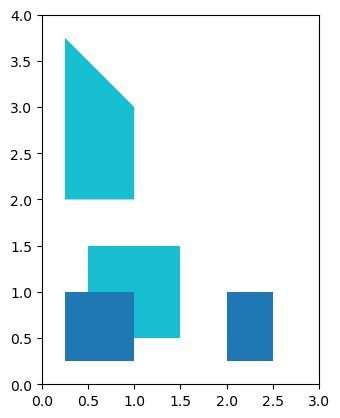

In [37]:
df_unique_1 = gpd.overlay(df1, df2, how='difference')  # Get df1 polygons that are not in df2
df_unique_2 = gpd.overlay(df2, df1, how='difference')  # Get df2 polygons that are not in df1
df_overlap = gpd.overlay(df1, df2, how='intersection')  # Get overlap between df1 and df2
df_overlap['lab'] = df_overlap['lab_1']  # choose label that is to be used for overlap
df_overlap = df_overlap.drop(['lab_1', 'lab_2'], axis=1)
df_overlap['source'] = df_overlap['source_1']
df_overlap = df_overlap.drop(['source_1', 'source_2'], axis=1)
df_new = gpd.GeoDataFrame(pd.concat([df_unique_1, df_unique_2, df_overlap], ignore_index=True))  # Concatenate all polygons
# df_new = gpd.GeoDataFrame(pd.concat([df_unique_1, df_unique_2], ignore_index=True, sort=False))
df_new = df_new.dissolve(by='lab', as_index=False)  # Dissolve polygons with same label
df_new = df_new.explode().reset_index(drop=True)
print(df_new)
df_new.plot(column='lab')
plt.xlim([0, 3])
plt.ylim([0, 4])

In [32]:
df_new

,lab,source,source_1,source_2,geometry
0,A,df1,df1,df2,"POLYGON ((1.00000 0.25000, 0.25000 0.25000, 0...."
1,A,df1,df1,df2,"POLYGON ((2.50000 0.25000, 2.00000 0.25000, 2...."
2,C,df2,None,None,"POLYGON ((1.50000 1.50000, 1.50000 0.50000, 1...."
3,C,df2,None,None,"POLYGON ((1.00000 2.00000, 0.25000 2.00000, 0...."


With this, the iterative plan for multi-layered data is:
- Define ranking of layers. Layer-1 is to be on top, then layer-2 etc. 
- Merge layer 1 and 2, and make sure 1 is on top. 
- Then merge layer-1/2 and layer-3, and make sure 1/2 is on top. 
- Continue till all layers are done. 

## Create layer for overriding model predictions:

In [144]:
## Load OS data:

dir_gpkg = '/home/tplas/data/gis/os_mastermap/'

dict_gpkg_file_names = {'roads': 'trn_fts_roadtrackorpath.gpkg',
                        'buildings': 'bld_fts_buildingpart.gpkg',
                        'sites': 'lus_fts_site.gpkg',
                        'structures': 'str_fts_structure.gpkg',
                        'railways': 'trn_fts_rail.gpkg',
                        'water': 'wtr_fts_water.gpkg',
                        'land': 'lnd_fts_land.gpkg'}  # different OS layers

dict_gdfs = {}
dict_unique_descriptions = {}

for key, value in dict_gpkg_file_names.items():
    path_layer = os.path.join(dir_gpkg, value)
    dict_gdfs[key] = gpd.read_file(path_layer)
    dict_unique_descriptions[key] = dict_gdfs[key]['description'].unique()

    ## Assert all geometry types are polygons
    set_unique_geom_types = set([type(x) for x in dict_gdfs[key]['geometry']])
    for geom_type in set_unique_geom_types:
        assert geom_type in [shp.geometry.polygon.Polygon, shp.geometry.multipolygon.MultiPolygon], f'Unexpected geometry type {geom_type} for {key}'

## Load PD outline:
pol_pd_outline = lca.load_pols(path_dict['pd_outline'])
pol_pd_outline

,Year,MI_PRINX,geometry
0,2015,2,"POLYGON ((432454.300 367391.315, 432454.193 36..."


In [145]:
## Create mapping dict template (from OS description to LC label)

os_to_lc_mapping = {key: {} for key in dict_gdfs.keys()}  # separate dict for each OS layer
min_size_dict = {key: None for key in dict_gdfs.keys()}

## Roads:
road_exceptions = ['Cycle Way', 'Path', 'Path And Steps', 'Track']  # all too minor to be considered transport routes
assert (np.isin(road_exceptions, dict_unique_descriptions['roads'])).all(), 'Road exceptions not found in OS data'
for descr in dict_unique_descriptions['roads']:
    if descr not in road_exceptions:
        os_to_lc_mapping['roads'][descr] = 'H1b'

# ## Buildings:
# for descr in dict_unique_descriptions['buildings']:
#     os_to_lc_mapping['buildings'][descr] = 'H1a'
## Better to use site layer .. ? [Private Residential Site]

## Sites:
other_isol_dev_list = ['Fish Farm']
skip_dev_list = ['Amenity And Open Space Site', 'Mine', 'Outdoor Activity Centre']
assert (np.isin(skip_dev_list, dict_unique_descriptions['sites'])).all(), 'Skip development exceptions not found in OS data'
assert (np.isin(other_isol_dev_list, dict_unique_descriptions['sites'])).all(), 'Other isolated development exceptions not found in OS data'
for descr in dict_unique_descriptions['sites']:
    if descr == 'Farm Site':
        os_to_lc_mapping['sites'][descr] = 'H3a'
    elif descr in other_isol_dev_list:
        os_to_lc_mapping['sites'][descr] = 'H3b' 
    elif descr == 'Quarry':
        os_to_lc_mapping['sites'][descr] = 'H2a'  # some false positives in here! See #TODO below
    elif descr in ['Rail Freight Transport' 'Rail Maintenance Site' 'Railway Station']:
        os_to_lc_mapping['sites'][descr] = 'H1b'
    elif descr in skip_dev_list:
        continue
    else:
        os_to_lc_mapping['sites'][descr] = 'H1a'

#################
## RE quarries:
## Maybe a extract all from OS Land and then if description | IS NOT['Quarry']
## We could create H2c disused or restored quarry workings
## oslandusetiera | Commercial Activity: Industrial Or Manufacturing
## description | Heath Or Rough Grassland And Scattered Boulders Or Scattered Rock
## description | Quarry
#################

## Structures 
## Think we can ignore these; mostly covered by sites for urban staff anyway. otherwise lots of tiny structures that are not relevant.

## Railways:
for descr in dict_unique_descriptions['railways']:
    os_to_lc_mapping['railways'][descr] = 'H1b'

## Water:
water_exceptions = ['Collects', 'Drain', 'Leat', 'Mill Leat', 'Open Tank Reservoir', 'Open Water Tank', 
                    'Overflow', 'Paddling Pool', 'Reed Bed For Waste Water', 'Settling Pond', 'Spreads',
                    'Spring', 'Swimming Pool', 'Watercourse', 'Waterfall']
assert (np.isin(water_exceptions, dict_unique_descriptions['water'])).all(), 'Water exceptions not found in OS data'
for descr in dict_unique_descriptions['water']:
    if descr not in water_exceptions:
        os_to_lc_mapping['water'][descr] = 'F2'
## Maybe add minimum area threshold for water? 
min_size_dict['water'] = 1000

## Land:
rock_list = ['Boulders Or Rock']
urban_land_list = ['Made Surface']
assert (np.isin(urban_land_list, dict_unique_descriptions['land'])).all(), 'Urban land exceptions not found in OS data'
assert (np.isin(rock_list, dict_unique_descriptions['land'])).all(), 'Rock exceptions not found in OS data'
for descr in dict_unique_descriptions['land']:
    if descr in rock_list:
        os_to_lc_mapping['land'][descr] = 'G2'
    elif descr in urban_land_list:
        os_to_lc_mapping['land'][descr] = 'H3b'




In [155]:
# with open('/home/tplas/repos/cnn-land-cover/content/os_to_lc_mapping.json', 'w') as fp:
#     json.dump(os_to_lc_mapping, fp, indent=4)

In [41]:
get_intersection_with_pd_outline = True 

dict_layers = {} 
if get_intersection_with_pd_outline:
    print('WARNING: getting intersection with PD will take considerably more time. (Minutes instead of seconds)')
## Loop through different layers & reduce to only features and attrs needed.
for it, (key, gdf_layer) in enumerate(dict_gdfs.items()):
    inds_use = gdf_layer['description'].isin(os_to_lc_mapping[key].keys())  # only use features with a mapping
    print(f'Using {np.sum(inds_use)}/{len(gdf_layer)} features from {key} layer')
    tmp_layer = gdf_layer.loc[inds_use, :].copy()
    
    if min_size_dict[key] is not None:  # apply area threshold if specified
        tmp_layer = tmp_layer.loc[tmp_layer['geometry'].area > min_size_dict[key], :]
        print(f'    Using {len(tmp_layer)} features from {key} layer after area thresholding')

    tmp_layer['lc_label'] = tmp_layer['description'].map(os_to_lc_mapping[key]) # add LC label
    
    tmp_layer = tmp_layer.drop(columns=[x for x in list(tmp_layer.columns) if x not in ['geometry', 'lc_label']])  # remove all columns that aren't relevant
    tmp_layer = tmp_layer.explode().reset_index(drop=True)  # explode multi-polygons into separate polygons
    if get_intersection_with_pd_outline:
        # tmp_layer = gpd.overlay(tmp_layer, pol_pd_outline, how='intersection')  # get intersection with PD outline
        tmp_layer = dgpd.from_geopandas(tmp_layer, npartitions=16)  # use dask geopandas to speed up intersection with lazy parallelization
        tmp_layer = tmp_layer.clip(pol_pd_outline).compute()  # get intersection with PD outline
        tmp_layer = tmp_layer.sort_index()
    dict_layers[key] = tmp_layer.copy()    

    

Using 24745/34716 features from roads layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


Using 0/56423 features from buildings layer
Using 19704/19729 features from sites layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


Using 0/3089 features from structures layer
Using 328/328 features from railways layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


Using 6943/6943 features from water layer
    Using 1038 features from water layer after area thresholding


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


Using 19968/180798 features from land layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


In [42]:
for key, val in dict_layers.items():
    print(f'Layer {key} has {val.crs}')

Layer roads has epsg:27700
Layer buildings has epsg:27700
Layer sites has epsg:27700
Layer structures has epsg:27700
Layer railways has epsg:27700
Layer water has epsg:27700
Layer land has epsg:27700


In [43]:
dissolve_polygons = True

ranking_keys = ['water', 'sites', 'railways','roads', 'land']
n_keys = len(ranking_keys)
df_new = None 
if dissolve_polygons:
    print('WARNING: dissolving polygons takes considerably more time (hours instead of minutes).')
for i_rank in range(n_keys - 1):
    key_1 = ranking_keys[i_rank]
    key_2 = ranking_keys[i_rank + 1]

    if df_new is None:
        print(f'Overlaying {key_1} and {key_2} layers')
        df1 = dict_layers[key_1]
    else:
        print(f'Overlaying {key_2} layer')
        df1 = df_new
    df2 = dict_layers[key_2]
    # print(f'CRS: {df1.crs}, {df2.crs}')
    df_unique_1 = gpd.overlay(df1, df2, how='difference')  # Get df1 polygons that are not in df2
    df_unique_2 = gpd.overlay(df2, df1, how='difference')  # Get df2 polygons that are not in df1

    ## The line below throws the CRS warning message, not sure why because CRS is specified for both df1 and df2
    df_overlap = gpd.overlay(df1, df2, how='intersection')  # Get overlap between df1 and df2
    # print(f'CRS of overlap: {df_overlap.crs}')
    df_overlap['lc_label'] = df_overlap['lc_label_1']  # choose label that is to be used for overlap
    df_overlap = df_overlap.drop(['lc_label_1', 'lc_label_2'], axis=1)
    # print(f'CRS: {df_unique_1.crs}, {df_unique_2.crs}, {df_overlap.crs}')
    df_new = gpd.GeoDataFrame(pd.concat([df_unique_1, df_unique_2, df_overlap], ignore_index=True))  # Concatenate all polygons
    if dissolve_polygons:
        df_new = df_new.dissolve(by='lc_label', as_index=False)  # Dissolve polygons with same label
        df_new = df_new.explode().reset_index(drop=True)  # explode multi-polygons into separate polygons
        

Overlaying water and sites layers


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: `keep_geom_type=True` in overlay resulted in 270 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700



Overlaying railways layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: `keep_geom_type=True` in overlay resulted in 112 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Currently, index_parts default

Overlaying roads layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: `keep_geom_type=True` in overlay resulted in 11979 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Currently, index_parts defau

Overlaying land layer


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: `keep_geom_type=True` in overlay resulted in 15841 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Currently, index_parts defau

In [15]:
df_new

,lc_label,geometry
0,F2,"POLYGON ((404838.800 394824.200, 404839.750 39..."
1,F2,"POLYGON ((398619.630 369739.780, 398618.700 36..."
2,F2,"POLYGON ((425538.300 365733.680, 425530.470 36..."
3,F2,"POLYGON ((425415.000 386836.000, 425519.840 38..."
4,F2,"POLYGON ((395084.690 378521.910, 395085.100 37..."
...,...,...
65716,H1a,"POLYGON ((411390.350 379236.020, 411382.160 37..."
65717,H1a,"POLYGON ((415481.918 359114.248, 415482.100 35..."
65718,H1a,"POLYGON ((424506.230 377811.880, 424509.950 37..."
65719,H1a,"POLYGON ((406646.400 355270.390, 406646.470 35..."


In [44]:
df_new.to_file('tmp_fgh_layer/tmp_fgh_layer.shp')  # TODO: SAVE CRS!!

## Overriding model predictions with this layer:

- It's straightforward in principle, but I just expect the runtime to be quite long..
- But it's the same procedure as used above when merging layers: just take the difference (pred - FGH) and then add FGH
- Will see if it can be sped up somehow, maybe using dask-geopandas?


In [5]:
filepath_manual_layer = '/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp'
df_fgh = gpd.read_file(filepath_manual_layer)
date_fgh_modified = str(datetime.datetime.strptime(time.ctime(os.path.getmtime(filepath_manual_layer)), '%a %b %d %H:%M:%S %Y').date())
    

In [24]:
date_fgh_modified

'2023-01-10'

In [6]:
df_fgh['source'] = f'OS NGD retrieved {date_fgh_modified}'
df_fgh 

,lc_label,geometry,source
0,F2,"POLYGON ((400841.890 360432.090, 400841.600 36...",OS NGD retrieved 2023-01-10
1,F2,"POLYGON ((399308.710 360858.520, 399311.100 36...",OS NGD retrieved 2023-01-10
2,F2,"POLYGON ((398209.238 361574.805, 398211.921 36...",OS NGD retrieved 2023-01-10
3,F2,"POLYGON ((399679.571 362509.906, 399682.710 36...",OS NGD retrieved 2023-01-10
4,F2,"POLYGON ((397708.580 363577.710, 397708.910 36...",OS NGD retrieved 2023-01-10
...,...,...,...
18051,H3b,"POLYGON ((427553.290 395338.570, 427552.560 39...",OS NGD retrieved 2023-01-10
18052,H3b,"POLYGON ((427769.030 395617.170, 427771.450 39...",OS NGD retrieved 2023-01-10
18053,H3b,"POLYGON ((427765.920 395621.030, 427765.720 39...",OS NGD retrieved 2023-01-10
18054,H3b,"POLYGON ((427845.770 395627.500, 427844.170 39...",OS NGD retrieved 2023-01-10


In [3]:
## Load FGH layer & get list of tile paths, and new directory for tile predictions with FGH override
df_fgh = gpd.read_file('//home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp')

tile_predictions_folder = '/home/tplas/predictions_LCU_2022-11-30-1205_dissolved1000m2/'
new_tile_predictions_override_folder = '/home/tplas/predictions_LCU_2022-11-30-1205_dissolved1000m2_FGH-override/'
if not os.path.exists(new_tile_predictions_override_folder):
    os.mkdir(new_tile_predictions_override_folder)
subdirs_tiles = [os.path.join(tile_predictions_folder, x) for x in os.listdir(tile_predictions_folder) if os.path.isdir(os.path.join(tile_predictions_folder, x))]
dict_shp_files = {} 
dict_new_shp_files = {}
for tile_dir in subdirs_tiles:
    ## Get tile name
    tilename = tile_dir.split('/')[-1].split('_')[2]
    assert len(tilename) == 6

    ## Get path to shp file
    tmp_list_shp_files = [os.path.join(tile_dir, x) for x in os.listdir(tile_dir) if x[-4:] == '.shp']
    assert len(tmp_list_shp_files) == 1 
    dict_shp_files[tilename] = tmp_list_shp_files[0]

    ## Set path for new shp file to be saved
    new_dir = os.path.join(new_tile_predictions_override_folder, tile_dir.split('/')[-1] + '_FGH-override')
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)

    ## Load shp file to see how many pols there are (takes some extra time)
    dict_new_shp_files[tilename] = os.path.join(new_dir, new_dir.split('/')[-1] + '.shp')
    tmp_pols = lca.load_pols(dict_shp_files[tilename])
    if len(tmp_pols) > 20:
        print(f'Loaded {len(tmp_pols)} polygons for tile {tilename}')


DriverError: tmp_fgh_layer/tmp_fgh_layer.shp: No such file or directory

In [ ]:
## Loop over tiles and apply FGH override
mapping_dict = {'Wood and Forest Land': 'C', 'Moor and Heath Land': 'D', 
                'Agro-Pastoral Land': 'E', 'NO CLASS': 'I'}
print(dict_shp_files.keys())
for tilename, tile_pred_path in tqdm(dict_shp_files.items()):
    print(tilename)
    df_pred = gpd.read_file(tile_pred_path)
    df_pred = df_pred.copy()
    df_pred = df_pred.drop(['class', 'area'], axis=1)
    if len(df_pred) == 1:  # just to verify that what's happening is what I think is happening
        assert 'polygon_id' not in df_pred.columns
    else:
        df_pred = df_pred.drop(['polygon_id'], axis=1)
    df_pred['lc_label'] = df_pred['Class name'].map(mapping_dict)
    df_pred = df_pred.drop(['Class name'], axis=1)
    # df_pred = df_pred.explode().reset_index(drop=True)  # explode multi-polygons into separate polygons
    df_diff = gpd.overlay(df_pred, df_fgh, how='difference')  # Get df pred polygons that are not in df fgh 
    df_diff = df_diff.explode().reset_index(drop=True)
    df_intersect = gpd.overlay(df_pred, df_fgh, how='intersection')  # Get overlap between df pred and df fgh
    df_intersect['lc_label'] = df_intersect['lc_label_2']
    df_intersect = df_intersect.drop(['lc_label_1', 'lc_label_2'], axis=1)
    df_intersect = df_intersect.explode().reset_index(drop=True)
    df_new = gpd.GeoDataFrame(pd.concat([df_diff, df_intersect], ignore_index=True))  # Concatenate all polygons
    df_new = lca.add_main_category_index_column(df_lc=df_new, col_code_name='lc_label',
                                                 col_ind_name='class')  # add numeric main label column
    df_new.crs = df_pred.crs
    # df_new = df_new.explode().reset_index(drop=True)
    
    new_tile_path = dict_new_shp_files[tilename]
    df_new.to_file(new_tile_path)


In [62]:
## Temp fix:
if False:
    for tilename, tile_pred_path in tqdm(dict_new_shp_files.items()):
        # print(tilename)
        df_pred = gpd.read_file(tile_pred_path)
        df_new = lca.add_main_category_index_column(df_lc=df_pred, col_code_name='lc_label',
                                                    col_ind_name='class')  # add numeric main label column
        df_new.crs = tmp_pols.crs
        df_new.to_file(tile_pred_path)
        # break 


100%|██████████| 50/50 [00:06<00:00,  8.09it/s]


#### Override 2022 annotations:

In [7]:
## Load FGH layer & get list of tile paths, and new directory for tile predictions with FGH override
df_fgh = gpd.read_file('/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp')
df_fgh['Class_Code'] = df_fgh['lc_label'].apply(lambda x: x[0])
df_fgh['Class_low'] = df_fgh['lc_label']
df_fgh = df_fgh.drop(['lc_label'], axis=1)

eval_pols_path = '/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022/landscape_character_2022.shp'
new_eval_pols_override_path = '/home/tplas/repos/cnn-land-cover/content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp'

eval_pols = lca.load_pols(eval_pols_path)
eval_pols['Class_low'] = eval_pols['Class_Code']
eval_pols = eval_pols.drop(['AREA', 'PERIMETER', 'LC_N_80', 'LC_D_80', 'MI_PRINX', 'Code'], axis=1)
# eval_pols.head()

df_diff = gpd.overlay(eval_pols, df_fgh, how='difference')  # Get df pred polygons that are not in df fgh 
df_diff = df_diff.explode().reset_index(drop=True)
df_intersect = gpd.overlay(eval_pols, df_fgh, how='intersection')  # Get overlap between df pred and df fgh
df_intersect['Class_Code'] = df_intersect['Class_Code_2']
df_intersect = df_intersect.drop(['Class_Code_1', 'Class_Code_2'], axis=1)
df_intersect['Class_low'] = df_intersect['Class_low_2']
df_intersect = df_intersect.drop(['Class_low_1', 'Class_low_2'], axis=1)
df_intersect = df_intersect.explode().reset_index(drop=True)
df_new = gpd.GeoDataFrame(pd.concat([df_diff, df_intersect], ignore_index=True))  # Concatenate all polygons
df_new = df_new.dissolve(by='Class_low', as_index=False)  # Dissolve polygons with same label
df_new = df_new.explode().reset_index(drop=True)  # explode multi-polygons into separate polygons
df_new['Class_high'] = df_new['Class_Code']
df_new = df_new.drop(['Class_Code'], axis=1)
df_new.crs = eval_pols.crs

df_new.to_file(new_eval_pols_override_path)

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB_1936_British_National_Grid",GEOGCS["G ...
Right CRS: None

  from ipykernel import kernelapp as app
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB_1936_Britis

In [8]:
tmp = gpd.read_file(new_eval_pols_override_path)
tmp

,Class_low,Class_high,geometry
0,C,C,"POLYGON ((405134.613 354056.340, 405141.829 35..."
1,C,C,"POLYGON ((405817.887 354457.575, 405821.021 35..."
2,C,C,"POLYGON ((405116.150 354565.590, 405116.300 35..."
3,C,C,"POLYGON ((405122.140 354531.540, 405121.650 35..."
4,C,C,"POLYGON ((405088.161 354722.453, 405097.632 35..."
...,...,...,...
1688,H3b,H,"POLYGON ((424178.429 396246.398, 424179.660 39..."
1689,H3b,H,"POLYGON ((424309.522 396249.667, 424310.680 39..."
1690,H3b,H,"POLYGON ((424374.990 396246.520, 424373.400 39..."
1691,H3b,H,"POLYGON ((424751.859 396847.889, 424762.494 39..."


In [133]:
## Save as tiffs:
tiff_dir_path = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022_FGH-override'
if os.path.exists(tiff_dir_path) is False:
    os.mkdir(tiff_dir_path)
    
outline_eval_tiles = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
dict_intersect_pols_tiles_eval = lca.get_pols_for_tiles(df_pols=df_new, df_tiles=outline_eval_tiles,
                                                       col_name='PLAN_NO', extract_main_categories_only=True)

for tile_name, df_tile in tqdm(dict_intersect_pols_tiles_eval.items()):

    df_tile = lca.add_main_category_index_column(df_lc=df_tile, col_code_name='Class_Code', 
                                                col_ind_name='class')  # add numeric main label column 
    ds_tile = lca.convert_shp_mask_to_raster(df_shp=df_tile, col_name='class',
                                            plot_raster=False, save_raster=True, verbose=0,
                                            maskdir=tiff_dir_path, filename=f'{tile_name}_lc_2022_FGH-override_mask.tif')

100%|██████████| 50/50 [02:44<00:00,  3.29s/it]


## Evaluate difference between override & non-override predictions:

In [137]:
## Evaluate difference in accuracy

LCU = lcm.load_model(filename='scripts/LCU_2022-11-30-1205.data')
LCU.eval()                         

stats_pred_vs_2022_dissolved_override = lca.compute_confusion_mat_from_dirs(dir_mask_true='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022_FGH-override',
                                            dir_mask_pred_shp=new_tile_predictions_override_folder,
                                            # dir_mask_pred_tif='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_80s/',
                                            # path_mapping_pred_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl',
                                            lc_class_name_list=LCU.dict_training_details['class_name_list'],
                                            unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])),
                                            skip_factor=None, col_name_shp_file='class')
                                            

stats_pred_vs_2022_dissolved = lca.compute_confusion_mat_from_dirs(dir_mask_true='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022_FGH-override',
                                            dir_mask_pred_shp=tile_predictions_folder,
                                            # dir_mask_pred_tif='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_80s/',
                                            # path_mapping_pred_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl',
                                            lc_class_name_list=LCU.dict_training_details['class_name_list'],
                                            unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])),
                                            skip_factor=None, col_name_shp_file='class')
                                            

Loaded LCU model
n_max_epochs is 15
Loading predicted mask shp files


50it [04:08,  4.97s/it]


Loading predicted mask shp files


50it [04:11,  5.02s/it]


In [84]:
stats_pred_vs_2022_dissolved[1]['SK2055']

,class name,class shortcut,sensitivity,precision,true density,predicted density
0,NO CLASS,0,0.000000,NaN,0.000019,0.000000
1,Wood and Forest Land,C,0.447859,0.185928,0.119319,0.287414
2,Moor and Heath Land,D,NaN,0.000000,0.000000,0.330220
3,Agro-Pastoral Land,E,0.626863,0.938626,0.572532,0.382366
4,Water and Wetland,F,NaN,NaN,0.000000,0.000000
5,Rock and Coastal Land,G,NaN,NaN,0.000000,0.000000
6,Developed Land,H,0.000000,NaN,0.308130,0.000000


In [78]:
np.mean(list(stats_pred_vs_2022_dissolved_override[0].values()))

0.8694310621473523

Text(15.722222222222223, 0.5, 'LC 2022')

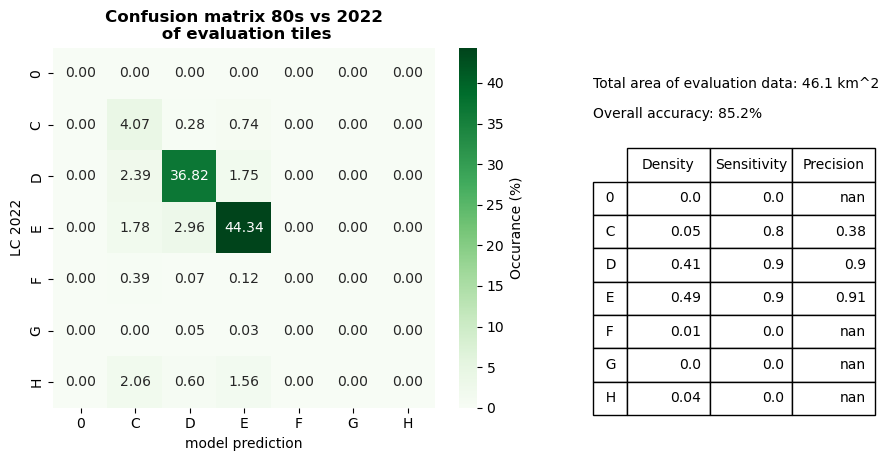

In [142]:
total_conf_mat = np.array(list(stats_pred_vs_2022_dissolved[2].values())).sum(0)

tmp = lcv.plot_confusion_summary(model=None, conf_mat=total_conf_mat, class_name_list=LCU.dict_training_details['class_name_list'],
                           normalise_hm=True)
                           
tmp[3][0].set_title('Confusion matrix 80s vs 2022\n of evaluation tiles', weight='bold')
tmp[3][0].set_xlabel('model prediction')
tmp[3][0].set_ylabel('LC 2022')

## Print OS label names:

In [53]:
for key, descr_list in dict_unique_descriptions.items():
    if key == 'land':
        print(key, len(descr_list))
        print(np.sort(descr_list))
        print('\n\n')

land 73
['Arable Or Grazing Land' 'Bare Earth Or Grass' 'Boulders Or Rock'
 'Boulders Or Rock And Heath Or Rough Grassland'
 'Boulders Or Rock And Heath Or Rough Grassland And Marsh'
 'Boulders Or Rock And Heath Or Rough Grassland And Scattered Coniferous Trees'
 'Boulders Or Rock And Heath Or Rough Grassland And Scattered Non-Coniferous Trees'
 'Boulders Or Rock And Heath Or Rough Grassland Or Marsh'
 'Boulders Or Rock And Scattered Mixed Trees'
 'Boulders Or Rock And Scattered Non-Coniferous Trees' 'Coniferous Trees'
 'Coniferous Trees And Scattered Boulders Or Scattered Rock'
 'Coniferous Trees And Scattered Boulders Or Scattered Rock And Scrub'
 'Coniferous Trees And Scrub' 'Construction Site' 'Gallops' 'Games Court'
 'Heath' 'Heath Or Rough Grassland' 'Heath Or Rough Grassland And Marsh'
 'Heath Or Rough Grassland And Marsh And Scattered Coniferous Trees'
 'Heath Or Rough Grassland And Marsh And Scattered Non-Coniferous Trees'
 'Heath Or Rough Grassland And Marsh And Scrub'
 'Heat